In [4]:
import os
import sys
import gc
import numpy as np
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?')

In [5]:
mu = 1e-3 #dynamic viscosity of water

In [6]:
df_surface = pd.read_csv('surface_data-t=5.0.csv')
df_surface

,p,dUdt:0,dUdt:1,dUdt:2,U:0,U:1,U:2,grad(U):0,grad(U):1,grad(U):2,...,grad(U):5,grad(U):6,grad(U):7,grad(U):8,Area,Normals:0,Normals:1,Normals:2,Cell ID,Block Number
0,0.917458,0.000000,0.000002,-0.000065,0.000000,-0.000002,0.004778,-0.408749,0.0,0.0,...,682.583,-0.049298,0.108494,0.5016,4.375000e-11,1,0,0,0,2
1,0.917458,0.000000,0.000002,-0.000065,0.000000,-0.000002,0.004778,-0.408749,0.0,0.0,...,628.559,-0.049298,0.108494,0.5016,4.375000e-11,1,0,0,1,2
2,0.917991,0.000000,0.000006,-0.000169,0.000000,-0.000009,0.013578,-0.965296,0.0,0.0,...,1159.390,-0.095318,0.156220,0.7920,4.375000e-11,1,0,0,2,2
3,0.918500,0.000000,0.000009,-0.000241,0.000000,-0.000013,0.021010,-1.324450,0.0,0.0,...,979.950,-0.116568,0.156112,0.8720,4.375000e-11,1,0,0,3,2
4,0.918913,0.000000,0.000011,-0.000292,0.000000,-0.000015,0.027297,-1.567000,0.0,0.0,...,829.293,-0.126608,0.118696,0.8960,4.375000e-11,1,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9679,0.000000,-0.000056,0.000076,-0.002668,0.000185,-0.000098,0.136725,-22.161400,0.0,0.0,...,0.000,-0.800080,-0.073112,9.6000,8.777990e-11,0,0,-1,1381,6
9680,0.000000,-0.000056,0.000076,-0.002668,0.000185,-0.000098,0.136725,-22.161400,0.0,0.0,...,1364.430,-0.800080,-0.073112,9.6000,8.777160e-11,0,0,-1,1382,6
9681,0.000000,-0.000033,0.000027,-0.001410,0.000099,-0.000046,0.165468,-11.930100,0.0,0.0,...,1364.430,-0.463528,0.346568,4.4800,8.777160e-11,0,0,-1,1383,6
9682,0.000000,-0.000033,0.000027,-0.001410,0.000099,-0.000046,0.165468,-11.930100,0.0,0.0,...,0.000,-0.463528,0.346568,4.4800,8.777990e-11,0,0,-1,1384,6


In [7]:
'''I think the best way to do things might be to make two new columns, one with the normal vector in it, the other with all 9 grad(U) components, then
make a method that does the required linear algebra'''

df_surface['grad_U'] = df_surface[['grad(U):0', 'grad(U):1', 'grad(U):2', 'grad(U):3', 'grad(U):4', 'grad(U):5', 'grad(U):6', 'grad(U):7', 'grad(U):8']].values.tolist()
df_surface['grad_U'] = df_surface['grad_U'].apply(np.array)
#df_surface['grad_U']

df_surface['normals'] = df_surface[['Normals:0', 'Normals:1', 'Normals:2']].values.tolist()
df_surface['normals'] = df_surface['normals'].apply(np.array)

In [8]:
def surface_integrand(row):
    '''
    this method works out the vector which is used as the integrand for the surface integrals.
    
    It also multiplies it by the area of the cell so we can then sum the integrands up
    to approximate the surface integral.
    '''
    gradU = row['grad_U'].reshape(3, 3)
    #norm_v = row['normals'].reshape(3, 1)
    norm_v = row['normals']
    p = row['p']
    area = row['Area']
    
    sigma = mu*(gradU + gradU.T) - p*np.identity(3)
#     print(sigma)
#     print(norm_v)
#     i=sigma@norm_v
#     print(i)
#     sys.exit()
    #return np.dot(sigma, norm_v)*area
    return (sigma@norm_v)*area

In [9]:
df_surface['surface_integrand']=df_surface.apply(surface_integrand, axis=1)

In [10]:
df_surface

,p,dUdt:0,dUdt:1,dUdt:2,U:0,U:1,U:2,grad(U):0,grad(U):1,grad(U):2,...,grad(U):8,Area,Normals:0,Normals:1,Normals:2,Cell ID,Block Number,grad_U,normals,surface_integrand
0,0.917458,0.000000,0.000002,-0.000065,0.000000,-0.000002,0.004778,-0.408749,0.0,0.0,...,0.5016,4.375000e-11,1,0,0,0,2,"[-0.408749, 0.0, 0.0, -0.486604, -0.3457030000...","[1, 0, 0]","[-4.01745530375e-11, -2.1288925e-14, -2.15677e..."
1,0.917458,0.000000,0.000002,-0.000065,0.000000,-0.000002,0.004778,-0.408749,0.0,0.0,...,0.5016,4.375000e-11,1,0,0,1,2,"[-0.408749, 0.0, 0.0, -0.331276, -0.4801109999...","[1, 0, 0]","[-4.01745530375e-11, -1.4493325000000004e-14, ..."
2,0.917991,0.000000,0.000006,-0.000169,0.000000,-0.000009,0.013578,-0.965296,0.0,0.0,...,0.7920,4.375000e-11,1,0,0,2,2,"[-0.9652959999999999, 0.0, 0.0, -0.54505500000...","[1, 0, 0]","[-4.0246569650000005e-11, -2.3846156250000006e..."
3,0.918500,0.000000,0.000009,-0.000241,0.000000,-0.000013,0.021010,-1.324450,0.0,0.0,...,0.8720,4.375000e-11,1,0,0,3,2,"[-1.32445, 0.0, 0.0, -0.358157, -0.444338, 979...","[1, 0, 0]","[-4.0300264375e-11, -1.5669368750000003e-14, -..."
4,0.918913,0.000000,0.000011,-0.000292,0.000000,-0.000015,0.027297,-1.567000,0.0,0.0,...,0.8960,4.375000e-11,1,0,0,4,2,"[-1.567, 0.0, 0.0, -0.245414, -0.198614, 829.2...","[1, 0, 0]","[-4.0339556249999994e-11, -1.0736862500000002e..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9679,0.000000,-0.000056,0.000076,-0.002668,0.000185,-0.000098,0.136725,-22.161400,0.0,0.0,...,9.6000,8.777990e-11,0,0,-1,1381,6,"[-22.1614, 0.0, 0.0, 0.0, 0.0, 0.0, -0.80008, ...","[0, 0, -1]","[7.0230942392e-14, 6.4177640488e-15, -1.685374..."
9680,0.000000,-0.000056,0.000076,-0.002668,0.000185,-0.000098,0.136725,-22.161400,0.0,0.0,...,9.6000,8.777160e-11,0,0,-1,1382,6,"[-22.1614, 0.0, 0.0, -4.04714, 2.50932, 1364.4...","[0, 0, -1]","[7.0224301728e-14, -1.1975178703078082e-10, -1..."
9681,0.000000,-0.000033,0.000027,-0.001410,0.000099,-0.000046,0.165468,-11.930100,0.0,0.0,...,4.4800,8.777160e-11,0,0,-1,1383,6,"[-11.9301, 0.0, 0.0, -4.04714, 2.50932, 1364.4...","[0, 0, -1]","[4.06845942048e-14, -1.197886230158688e-10, -7..."
9682,0.000000,-0.000033,0.000027,-0.001410,0.000099,-0.000046,0.165468,-11.930100,0.0,0.0,...,4.4800,8.777990e-11,0,0,-1,1384,6,"[-11.9301, 0.0, 0.0, 0.0, 0.0, 0.0, -0.463528,...","[0, 0, -1]","[4.06884414872e-14, -3.04217043832e-14, -7.865..."


In [11]:
#to calculate the integral, simply sum up the surface_integrand column
#this works because all of the integrand values have been scaled by the cell area.
z = df_surface['surface_integrand'].sum()
print(z)

[ 1.36359299e-10  9.61581755e-08 -3.03561445e-07]


In [12]:
def scale_w(row):
    return row['U:2']*row['Area']

In [13]:
df_surface['scaled_w']=df_surface.apply(scale_w, axis=1)

In [14]:
y = df_surface['scaled_w'].sum()
print(y)

5.2279892087705935e-08


In [15]:
'''I'LL DO THE VOLUME INTEGRATION STUFF HERE TOO, THEN TIDY UP THE LAYOUT AFTERWARDS '''

"I'LL DO THE VOLUME INTEGRATION STUFF HERE TOO, THEN TIDY UP THE LAYOUT AFTERWARDS "

In [16]:
m = np.arange(9).reshape(3,3)
u = np.power(10, np.arange(3))
r = u*m
print(m)
print()
print(u)
print()
print(r)

v = np.sum(r, axis=1).reshape(3, 1)
print(v)


[[0 1 2]
 [3 4 5]
 [6 7 8]]

[  1  10 100]

[[  0  10 200]
 [  3  40 500]
 [  6  70 800]]
[[210]
 [543]
 [876]]


In [17]:
df_volume = pd.read_csv('volume_data-t=5.0.csv')
df_volume

,p,dUdt:0,dUdt:1,dUdt:2,U:0,U:1,U:2,grad(U):0,grad(U):1,grad(U):2,grad(U):3,grad(U):4,grad(U):5,grad(U):6,grad(U):7,grad(U):8,Area,Volume,Cell ID,Block Number
0,0.916462,5.304250e-07,4.506720e-07,-0.000011,-7.880910e-07,-5.649040e-07,0.001959,0.174349,0.117571,-140.565,-0.112584,-0.080701,279.870,-0.027343,0.011892,0.1696,0.000000e+00,1.509370e-16,0,2
1,0.916324,2.393600e-07,2.102700e-07,-0.000009,-3.506040e-07,-2.330290e-07,0.001519,0.111206,0.081729,-131.612,-0.050086,-0.033290,216.969,-0.017587,0.006739,0.1464,0.000000e+00,1.509370e-16,1,2
2,0.916462,5.304250e-07,4.506720e-07,-0.000011,-7.880910e-07,-5.649040e-07,0.001959,0.174349,0.117571,-140.565,-0.330221,-0.415404,313.346,-0.027343,0.011892,0.1696,0.000000e+00,1.509370e-16,2,2
3,0.916324,2.393600e-07,2.102700e-07,-0.000009,-3.506040e-07,-2.330290e-07,0.001519,0.106315,0.078288,-124.674,-0.242737,-0.346365,271.221,-0.017587,0.006739,0.1464,0.000000e+00,1.509370e-16,3,2
4,0.916015,3.656030e-06,4.620320e-06,-0.000026,-5.411180e-06,-6.380560e-06,0.006346,0.604394,0.416700,-336.422,-0.872515,-1.015550,650.972,-0.124701,-0.079210,0.2776,0.000000e+00,1.509370e-16,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104911,0.000000,-5.615750e-05,7.595200e-05,-0.002668,1.846710e-04,-9.836450e-05,0.136725,-22.161400,0.000000,0.000,0.000000,0.000000,0.000,-0.800080,-0.073112,9.6000,8.777990e-11,0.000000e+00,1381,9
104912,0.000000,-5.615750e-05,7.595200e-05,-0.002668,1.846710e-04,-9.836450e-05,0.136725,-22.161400,0.000000,0.000,-4.047140,2.509320,1364.430,-0.800080,-0.073112,9.6000,8.777160e-11,0.000000e+00,1382,9
104913,0.000000,-3.326900e-05,2.740670e-05,-0.001410,9.941390e-05,-4.550320e-05,0.165468,-11.930100,0.000000,0.000,-4.047140,2.509320,1364.430,-0.463528,0.346568,4.4800,8.777160e-11,0.000000e+00,1383,9
104914,0.000000,-3.326900e-05,2.740670e-05,-0.001410,9.941390e-05,-4.550320e-05,0.165468,-11.930100,0.000000,0.000,0.000000,0.000000,0.000,-0.463528,0.346568,4.4800,8.777990e-11,0.000000e+00,1384,9


In [18]:
df_volume['grad_U'] = df_volume[['grad(U):0', 'grad(U):1', 'grad(U):2', 'grad(U):3', 'grad(U):4', 'grad(U):5', 'grad(U):6', 'grad(U):7', 'grad(U):8']].values.tolist()
df_volume['grad_U'] = df_volume['grad_U'].apply(np.array)

df_volume['dUdt'] = df_volume[['dUdt:0', 'dUdt:1', 'dUdt:2']].values.tolist()
df_volume['dUdt'] = df_volume['dUdt'].apply(np.array)

df_volume['U'] = df_volume[['U:0', 'U:1', 'U:2']].values.tolist()
df_volume['U'] = df_volume['U'].apply(np.array)

df_volume

,p,dUdt:0,dUdt:1,dUdt:2,U:0,U:1,U:2,grad(U):0,grad(U):1,grad(U):2,...,grad(U):6,grad(U):7,grad(U):8,Area,Volume,Cell ID,Block Number,grad_U,dUdt,U
0,0.916462,5.304250e-07,4.506720e-07,-0.000011,-7.880910e-07,-5.649040e-07,0.001959,0.174349,0.117571,-140.565,...,-0.027343,0.011892,0.1696,0.000000e+00,1.509370e-16,0,2,"[0.174349, 0.11757100000000001, -140.565, -0.1...","[5.30425e-07, 4.50672e-07, -1.1425e-05]","[-7.88091e-07, -5.64904e-07, 0.00195909]"
1,0.916324,2.393600e-07,2.102700e-07,-0.000009,-3.506040e-07,-2.330290e-07,0.001519,0.111206,0.081729,-131.612,...,-0.017587,0.006739,0.1464,0.000000e+00,1.509370e-16,1,2,"[0.111206, 0.0817293, -131.612, -0.05008630000...","[2.3936e-07, 2.1026999999999996e-07, -8.725e-06]","[-3.5060400000000003e-07, -2.3302900000000001e..."
2,0.916462,5.304250e-07,4.506720e-07,-0.000011,-7.880910e-07,-5.649040e-07,0.001959,0.174349,0.117571,-140.565,...,-0.027343,0.011892,0.1696,0.000000e+00,1.509370e-16,2,2,"[0.174349, 0.11757100000000001, -140.565, -0.3...","[5.30425e-07, 4.50672e-07, -1.1425e-05]","[-7.88091e-07, -5.64904e-07, 0.00195909]"
3,0.916324,2.393600e-07,2.102700e-07,-0.000009,-3.506040e-07,-2.330290e-07,0.001519,0.106315,0.078288,-124.674,...,-0.017587,0.006739,0.1464,0.000000e+00,1.509370e-16,3,2,"[0.106315, 0.0782878, -124.67399999999999, -0....","[2.3936e-07, 2.1026999999999996e-07, -8.725e-06]","[-3.5060400000000003e-07, -2.3302900000000001e..."
4,0.916015,3.656030e-06,4.620320e-06,-0.000026,-5.411180e-06,-6.380560e-06,0.006346,0.604394,0.416700,-336.422,...,-0.124701,-0.079210,0.2776,0.000000e+00,1.509370e-16,4,2,"[0.604394, 0.4167, -336.42199999999997, -0.872...","[3.6560300000000002e-06, 4.62032e-06, -2.6125e...","[-5.41118e-06, -6.38056e-06, 0.00634593]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104911,0.000000,-5.615750e-05,7.595200e-05,-0.002668,1.846710e-04,-9.836450e-05,0.136725,-22.161400,0.000000,0.000,...,-0.800080,-0.073112,9.6000,8.777990e-11,0.000000e+00,1381,9,"[-22.1614, 0.0, 0.0, 0.0, 0.0, 0.0, -0.80008, ...","[-5.61575e-05, 7.5952e-05, -0.0026675]","[0.000184671, -9.83645e-05, 0.136725]"
104912,0.000000,-5.615750e-05,7.595200e-05,-0.002668,1.846710e-04,-9.836450e-05,0.136725,-22.161400,0.000000,0.000,...,-0.800080,-0.073112,9.6000,8.777160e-11,0.000000e+00,1382,9,"[-22.1614, 0.0, 0.0, -4.04714, 2.50932, 1364.4...","[-5.61575e-05, 7.5952e-05, -0.0026675]","[0.000184671, -9.83645e-05, 0.136725]"
104913,0.000000,-3.326900e-05,2.740670e-05,-0.001410,9.941390e-05,-4.550320e-05,0.165468,-11.930100,0.000000,0.000,...,-0.463528,0.346568,4.4800,8.777160e-11,0.000000e+00,1383,9,"[-11.9301, 0.0, 0.0, -4.04714, 2.50932, 1364.4...","[-3.3269e-05, 2.74067e-05, -0.00141]","[9.94139e-05, -4.5503199999999995e-05, 0.165468]"
104914,0.000000,-3.326900e-05,2.740670e-05,-0.001410,9.941390e-05,-4.550320e-05,0.165468,-11.930100,0.000000,0.000,...,-0.463528,0.346568,4.4800,8.777990e-11,0.000000e+00,1384,9,"[-11.9301, 0.0, 0.0, 0.0, 0.0, 0.0, -0.463528,...","[-3.3269e-05, 2.74067e-05, -0.00141]","[9.94139e-05, -4.5503199999999995e-05, 0.165468]"


In [19]:
def volume_integrand(row):
    
    U = row['U']
    dUdt = row['dUdt']
    gradU = row['grad_U'].reshape(3, 3)
    V = row['Volume']
    
#     print(dUdt)
#     print()
#     print(gradU)
#     print()
#     print(U)
#     print()
    
    r = U*gradU.T #first step of calculating (U.grad)U
    #print(r)
    UgradU = np.sum(r, axis=1) #second step of calculating (U.grad)U
#     print()
#     print(UgradU)
    
    integrand = (dUdt + UgradU)*V
    #sys.exit()
    return integrand

In [20]:
df_volume['volume_integrand']=df_volume.apply(volume_integrand, axis=1)

In [223]:
vi = df_volume['volume_integrand'].sum()
print(vi)

[-1.50297490e-14 -5.94765883e-13  2.29180392e-11]


In [192]:
def scale_w(row):
    return row['U:1']*row['Volume']

In [193]:
df_volume['scaled_w']=df_volume.apply(scale_w, axis=1)

In [194]:
y = df_volume['scaled_w'].sum()
print(y)

8.856264967535774e-15


In [30]:
def calcDragOverTime(t_max, delta_t):
    t_list = []
    integ_vectors = [] #list to hold the vectors calculated from the integrals
    filename = 'drag_over_time.csv'
    
    with open(filename, 'x') as file:
        
        file.write('t, D_x, D_y, D_z,\n')
        
        for t in np.arange(delta_t, t_max+delta_t, delta_t):
            t_string = "{:.1f}".format(t)
            print(t_string)

            df_surface = pd.read_csv('surface_data-t='+t_string+'.csv')
            df_volume = pd.read_csv('volume_data-t='+t_string+'.csv')

            df_surface['grad_U'] = df_surface[['grad(U):0', 'grad(U):1', 'grad(U):2', 'grad(U):3', 'grad(U):4', 'grad(U):5', 'grad(U):6', 'grad(U):7', 'grad(U):8']].values.tolist()
            df_surface['grad_U'] = df_surface['grad_U'].apply(np.array)
            df_surface['normals'] = df_surface[['Normals:0', 'Normals:1', 'Normals:2']].values.tolist()
            df_surface['normals'] = df_surface['normals'].apply(np.array)

            df_volume['grad_U'] = df_volume[['grad(U):0', 'grad(U):1', 'grad(U):2', 'grad(U):3', 'grad(U):4', 'grad(U):5', 'grad(U):6', 'grad(U):7', 'grad(U):8']].values.tolist()
            df_volume['grad_U'] = df_volume['grad_U'].apply(np.array)
            df_volume['dUdt'] = df_volume[['dUdt:0', 'dUdt:1', 'dUdt:2']].values.tolist()
            df_volume['dUdt'] = df_volume['dUdt'].apply(np.array)
            df_volume['U'] = df_volume[['U:0', 'U:1', 'U:2']].values.tolist()
            df_volume['U'] = df_volume['U'].apply(np.array)


            df_surface['surface_integrand']=df_surface.apply(surface_integrand, axis=1)
            df_volume['volume_integrand']=df_volume.apply(volume_integrand, axis=1)

            surf_int = df_surface['surface_integrand'].sum()
            vol_int = df_volume['volume_integrand'].sum()
            total_int = surf_int + vol_int

            '''TODO, WRITE THIS STUFF TO A FILE'''
            t_list.append(t)
            integ_vectors.append(total_int)
            data_string = "{:.2f}, {:.5e}, {:.5e}, {:.5e}\n".format(t, total_int[0], total_int[1], total_int[2])
            file.write(data_string)

            del df_surface, df_volume
            gc.collect()
            
    return t_list, integ_vectors

In [31]:
t_vals, drag_vals = calcDragOverTime(t_max=15., delta_t=0.2)

0.2
0.4
0.6
0.8
1.0
1.2
1.4
1.6
1.8
2.0
2.2
2.4
2.6
2.8
3.0
3.2
3.4
3.6
3.8
4.0
4.2
4.4
4.6
4.8
5.0
5.2
5.4
5.6
5.8
6.0
6.2
6.4
6.6
6.8
7.0
7.2
7.4
7.6
7.8
8.0
8.2
8.4
8.6
8.8
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.2
11.4
11.6
11.8
12.0
12.2
12.4
12.6
12.8
13.0
13.2
13.4
13.6
13.8
14.0
14.2
14.4
14.6
14.8
15.0


In [29]:
# t_max = 10.
# delta_t = 0.2

# t_list = []
# integ_vectors = [] #list to hold the vectors calculated from the integrals

# for t in np.arange(delta_t, t_max+delta_t, delta_t):
#     t_string = "{:.1f}".format(t)
#     print(t_string)
    
#     df_surface = pd.read_csv('surface_data-t='+t_string+'.csv')
#     df_volume = pd.read_csv('volume_data-t='+t_string+'.csv')
    
#     df_surface['grad_U'] = df_surface[['grad(U):0', 'grad(U):1', 'grad(U):2', 'grad(U):3', 'grad(U):4', 'grad(U):5', 'grad(U):6', 'grad(U):7', 'grad(U):8']].values.tolist()
#     df_surface['grad_U'] = df_surface['grad_U'].apply(np.array)
#     df_surface['normals'] = df_surface[['Normals:0', 'Normals:1', 'Normals:2']].values.tolist()
#     df_surface['normals'] = df_surface['normals'].apply(np.array)
    
#     df_volume['grad_U'] = df_volume[['grad(U):0', 'grad(U):1', 'grad(U):2', 'grad(U):3', 'grad(U):4', 'grad(U):5', 'grad(U):6', 'grad(U):7', 'grad(U):8']].values.tolist()
#     df_volume['grad_U'] = df_volume['grad_U'].apply(np.array)
#     df_volume['dUdt'] = df_volume[['dUdt:0', 'dUdt:1', 'dUdt:2']].values.tolist()
#     df_volume['dUdt'] = df_volume['dUdt'].apply(np.array)
#     df_volume['U'] = df_volume[['U:0', 'U:1', 'U:2']].values.tolist()
#     df_volume['U'] = df_volume['U'].apply(np.array)
    
    
#     df_surface['surface_integrand']=df_surface.apply(surface_integrand, axis=1)
#     df_volume['volume_integrand']=df_volume.apply(volume_integrand, axis=1)
    
#     surf_int = df_surface['surface_integrand'].sum()
#     vol_int = df_volume['volume_integrand'].sum()
#     total_int = surf_int + vol_int
    
#     '''TODO, WRITE THIS STUFF TO A FILE'''
#     t_listist.append(t)
#     integ_vectors.append(total_int)
    
#     del df_surface, df_volume
#     gc.collect()
#     print(integ_vectors)

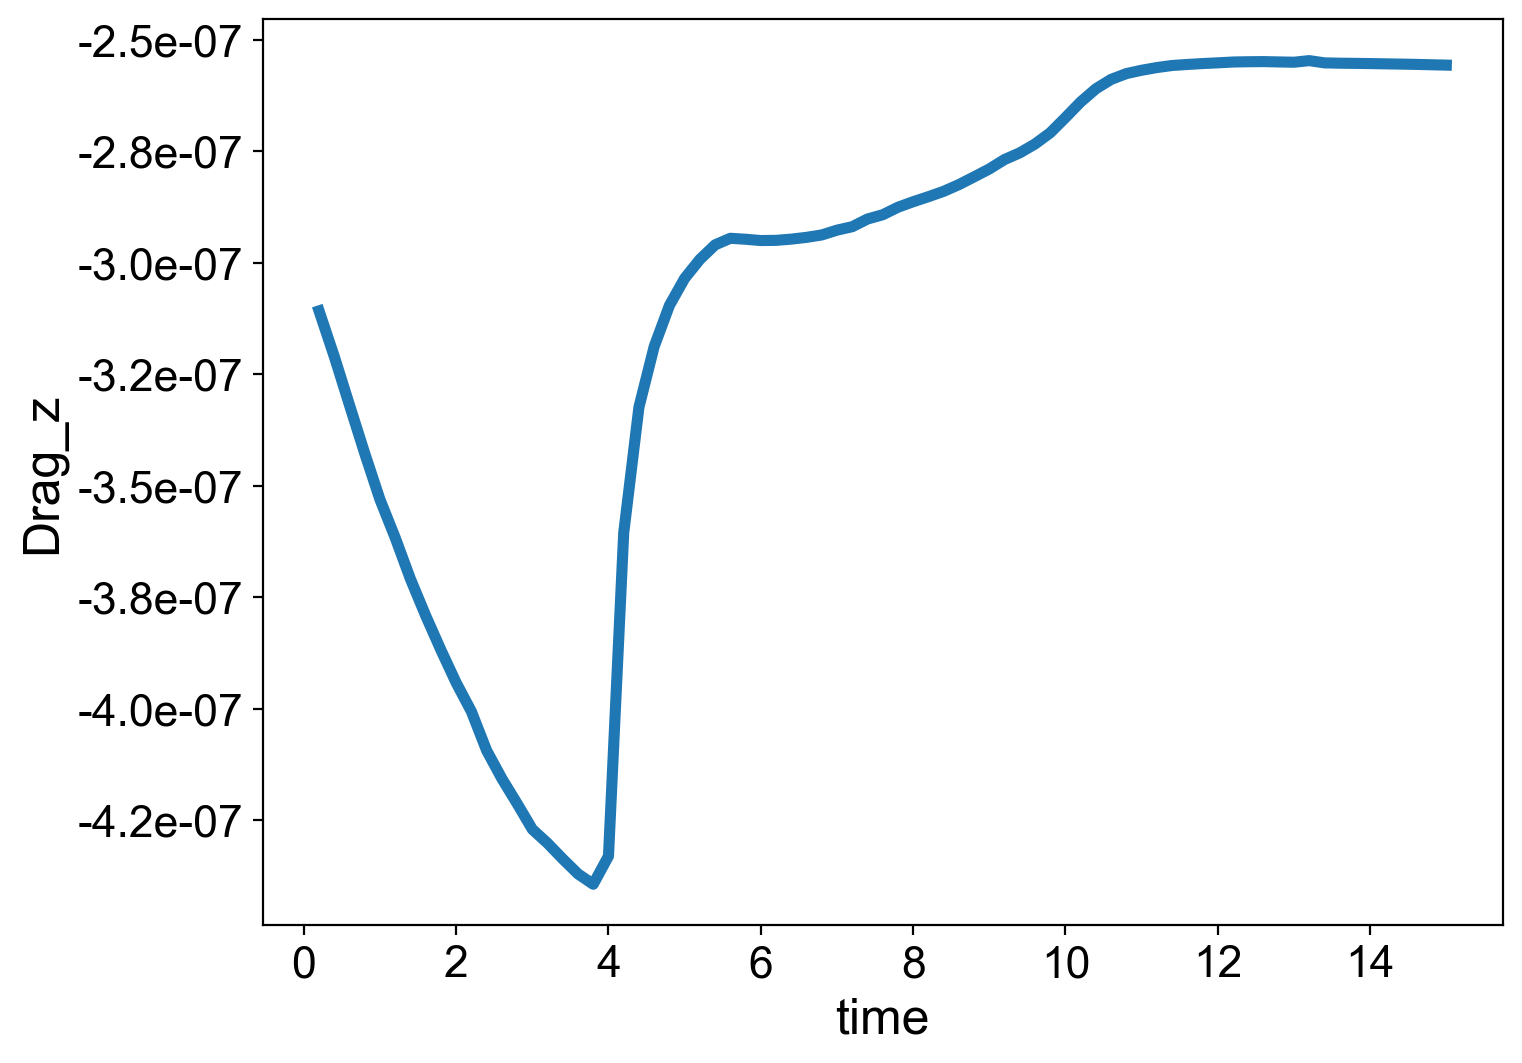

In [32]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
plt.rcParams['font.sans-serif'] = "Arial"

z_data = np.array(drag_vals)[:,2]
#print(z_data)
#t_vals = np.arange(delta_t, t_max+delta_t, delta_t)
ax.plot(t_vals, z_data, lw=4)
ax.set_xlabel('time', fontsize=18)
ax.set_ylabel('Drag_z', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.savefig('rough_integrals_v1.pdf')
plt.show()